Training samples: 25000
Test samples: 25000


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 27s 164ms/step - accuracy: 0.6650 - loss: 0.6635 - val_accuracy: 0.8652 - val_loss: 0.3502
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 27s 171ms/step - accuracy: 0.9014 - loss: 0.2854 - val_accuracy: 0.8742 - val_loss: 0.3196
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 27s 174ms/step - accuracy: 0.9300 - loss: 0.2137 - val_accuracy: 0.8366 - val_loss: 0.4257
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 27s 175ms/step - accuracy: 0.9427 - loss: 0.1788 - val_accuracy: 0.8680 - val_loss: 0.3642
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 27s 175ms/step - accuracy: 0.9593 - loss: 0.1426 - val_accuracy: 0.8560 - val_loss: 0.5049
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.8672 - loss: 0.3298
Test accuracy: 0.87


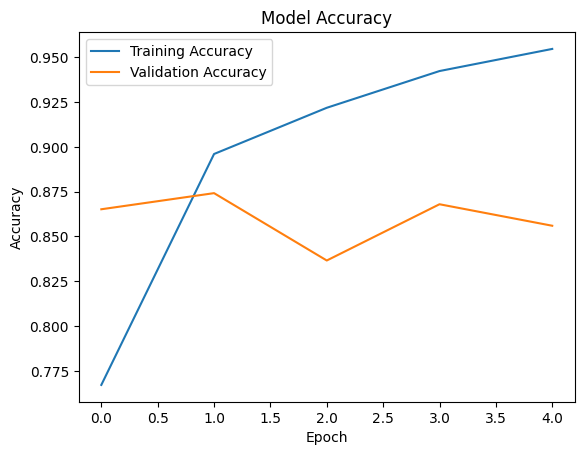

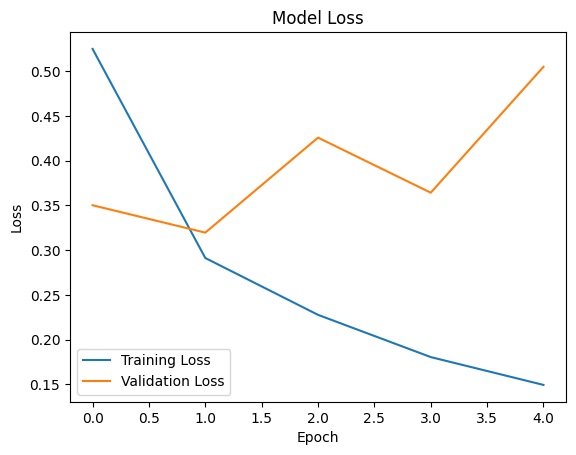

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Review: i loved the acting and the storyline was beautiful
Sentiment score: 0.66
→ Positive 😊


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

# Load the top 10,000 most frequent words
num_words = 10000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)

print(f"Training samples: {len(x_train)}")
print(f"Test samples: {len(x_test)}")

# Pad sequences to the same length
max_len = 200
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

model = Sequential()
model.add(Embedding(num_words, 32, input_length=max_len))
model.add(LSTM(64, return_sequences=True,
               kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(LSTM(32, kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # 👈 This ensures best model is kept
model.summary()

history = model.fit(
    x_train, y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop]
)

test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.2f}")

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.save("sentiment_model.h5")
model = load_model("sentiment_model.h5")

# Load word index used by IMDB (word → int)
word_index = imdb.get_word_index()

# Add special tokens
word_index = {k: (v + 3) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3

def encode_review(text):
    words = text.lower().split()  # Split the input text into lowercase words
    encoded = [1]  # Start with <START> token
    for word in words:
        if word in word_index:
            encoded.append(word_index[word])  # If word is in vocab, use its index
        else:
            encoded.append(2)  # If not, use <UNK> (unknown word) token
    return pad_sequences([encoded], maxlen=200)  # Pad/truncate to match model input length

def predict_review(text):
    encoded_input = encode_review(text)  # Preprocess text
    prediction = model.predict(encoded_input)[0][0]  # Get predicted score (0 to 1)
    print(f"Review: {text}")
    print(f"Sentiment score: {prediction:.2f}")
    if prediction >= 0.5:
        print("→ Positive 😊")
    else:
        print("→ Negative 😠")

predict_review("i loved the acting and the storyline was beautiful")